Classify hand-written letters through MNIST dataset.

In [1]:
import sys
import os

import numpy as np
import pandas as pd

# 1. Import the MNIST dataset

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

See a sample example:

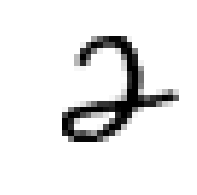

In [27]:
import matplotlib.pyplot as plt

sample = X[16]
sample_image = sample.reshape(28, 28)

plt.figure(figsize=(3,3))
plt.imshow(sample_image, cmap="binary")
plt.axis("off")
plt.show()

In [6]:
y[16]

'2'

Note the label is a string. Cast y to integers

In [7]:
y = y.astype(np.uint8)

## Split into training set and test set

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 2. Training a Binary Classifier
An example binary classifier that identifies if the image is 2 or not.

In [9]:
y_train_2 = (y_train == 2)
y_test_2 = (y_test == 2)
y_train_2[16]

True

## (Model 1): Stochastic Gradient Descent 
Using `SGDClassifier`

In [10]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd.fit(X_train, y_train_2)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [11]:
sgd.predict([sample])

array([ True])

## Evaluating using Cross-Validation

In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd, X_train, y_train_2, cv=3, scoring="accuracy")

array([0.97255, 0.90635, 0.97075])

## Confusion Matrix

In [13]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd, X_train, y_train_2, cv=3)

In [14]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_2, y_train_pred)

array([[51645,  2397],
       [  610,  5348]])

true negative, false positive

false negative, true positive

## Precision, Recall, F1 Score
Due to sampling bias (few 2 examples than others), we need to check the precision, recall and F1 score.

In [15]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_2, y_train_pred)

0.6905100064557779

In [16]:
recall_score(y_train_2, y_train_pred)

0.8976166498825109

In [17]:
from sklearn.metrics import f1_score

f1_score(y_train_2, y_train_pred)

0.7805590016784646

In [20]:
y_scores = cross_val_predict(sgd, X_train, y_train_2, cv=3,
                             method="decision_function")

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_2, y_scores)

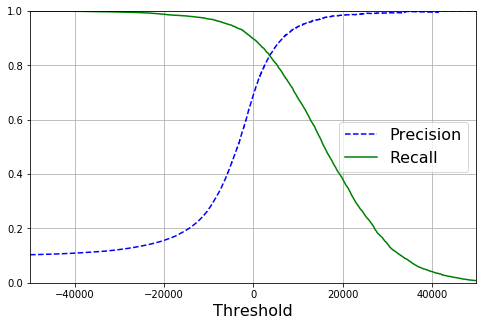

In [26]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

If we want 90\% precision

In [28]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] # ~7816
y_train_pred_90 = (y_scores >= threshold_90_precision)

## Trade off precision and recall
by changing the decision boundary

In [ ]:
y_scores = cross_val_predict(sgd, X_train, y_train_2, cv=3,
                             method="decision_function")

## ROC Curve (Receiver Operating Characteristic)

The ROC curve plots the true positive rate (another name for recall) against the false positive rate. The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to one minus the true negative rate, which is the ratio of negative instances that are correctly classified as negative. The TNR is also called specificity. Hence the ROC curve plots $Recall/ (1 – specificity)$.

In [29]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_2, y_scores)

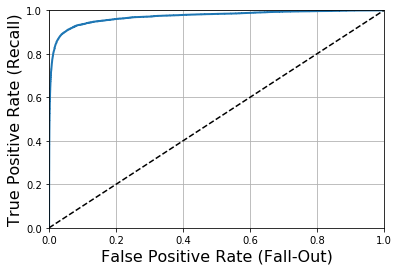

In [30]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown


plot_roc_curve(fpr, tpr)
plt.show()

The higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

One way to compare classifiers is to measure the __area under the curve (AUC)__. A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC AUC:

In [32]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_2, y_scores)

0.9715680525928145

## (Model 2) Random Forest Classifier
Note: it has `predict_proba()` rather than `decision_function()`

In [33]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_2, cv=3,
                                    method="predict_proba")

In [37]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_2,y_scores_forest)

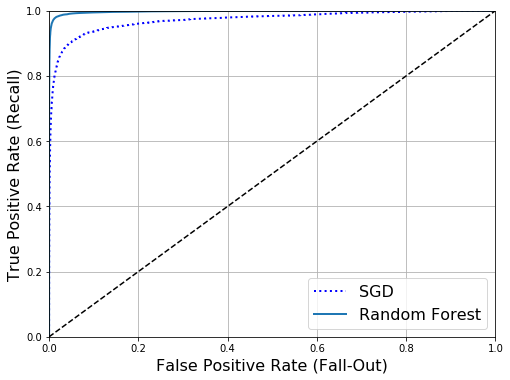

In [40]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [41]:
roc_auc_score(y_train_2, y_scores_forest)

0.9976087190102003

Ramdon Forest's ROC curve and AUC score look better than SCD's.

# 3. Multiclass Classification
Native Multiclass Classifiers:
- SGD classifiers, 
- Random Forest classifiers, or 
- naive Bayes classifiers

Binary Classifiers:
- Logistic Regression or 
- Support Vector Machine classifiers
However, there are various strategies that you can use to perform multiclass classification using multiple binary classifiers, eg.__on-vs-all__ and __one-vs-one__ (only works well with SVM).

## (Model 3): SVM + OvO
automatically use OvO if we do multiclass classification

In [42]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
svm_clf.predict([sample])

array([2], dtype=uint8)

In [45]:
some_digit_scores = svm_clf.decision_function([sample])
some_digit_scores

array([[ 3.92967083,  7.02198176,  9.5       ,  1.9094168 ,  5.97090489,
         0.90422253,  2.91452207,  8.02624662, -0.12187268,  4.94490718]])

In [47]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [48]:
np.argmax(some_digit_scores)

2

### Force to use OvA or OvO:
you can use the `OneVsOneClassifier` or `OneVsRestClassifier` classes.

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
# ovr_clf.fit(X_train, y_train)
# ovr_clf.predict([sample])

## (Model 3) Multiclass SGD
with scaling of the inputs

In [54]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.89707059, 0.8960948 , 0.90693604])

### Error Analysis

1. check the confusion matrix

In [55]:
y_train_pred = cross_val_predict(sgd, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5578,    0,   22,    7,    8,   45,   35,    5,  222,    1],
       [   0, 6410,   35,   26,    4,   44,    4,    8,  198,   13],
       [  28,   27, 5232,  100,   74,   27,   68,   37,  354,   11],
       [  23,   18,  115, 5254,    2,  209,   26,   38,  373,   73],
       [  11,   14,   45,   12, 5219,   11,   33,   26,  299,  172],
       [  26,   16,   31,  173,   54, 4484,   76,   14,  482,   65],
       [  31,   17,   45,    2,   42,   98, 5556,    3,  123,    1],
       [  20,   10,   53,   27,   50,   13,    3, 5696,  173,  220],
       [  17,   64,   47,   91,    3,  125,   24,   11, 5421,   48],
       [  24,   18,   29,   67,  116,   39,    1,  174,  329, 5152]])

2. Check the errors

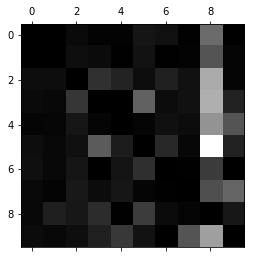

In [56]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

# 4. Multilabel Classification
a classification system that outputs multiple binary tags. Eg. face recognition in a photo.

Below we train a classifier to predict if a number is large and odd.

In [57]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [59]:
knn_clf.predict([sample])

array([[False, False]])

"2" is not large and not odd. 

# 5. Multioutput Classification
It is simply a generalization of multilabel classification where each label can be multiclass (i.e., it can have more than two possible values).

Sometimes similar to regression.

eg. Predict a cleaned image (pixel intensity values) from a noisy image.